In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../")

In [2]:
import math
import torch
import matplotlib.pyplot as plt

# install instructions here https://github.com/nicola-decao/power_spherical
from power_spherical import PowerSpherical

In [3]:
torch.manual_seed(123)

In [4]:
# here we create a PowerSpherical distribution with n_clusters locations around the unit circle
# see here for more info (https://arxiv.org/abs/2006.04437). TLDR: the PowerSpherical distribution 
# needs a directiona and a scale parameter and it has support on the n-sphere
n_clusters = 6

dist = PowerSpherical(
    loc=torch.tensor([
      [
          math.cos(2 * torch.pi * i / n_clusters),
          math.sin(2 * torch.pi * i / n_clusters)
      ]
      for i in range(n_clusters)
    ]),
    scale=torch.tensor([500. for _ in range(n_clusters)]),
)

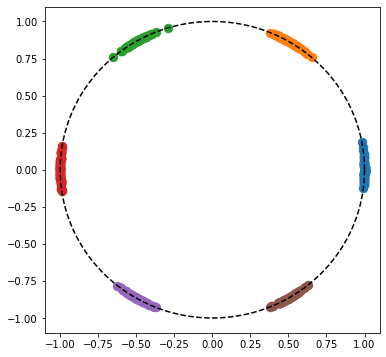

In [5]:
# here we sample from the distributions and we plot it
plt.figure(figsize=(6, 6))
t = torch.linspace(0, 2 * torch.pi, 1000)
plt.plot(torch.cos(t), torch.sin(t), "--", color="black")

n_samples = 100
samples = dist.sample((n_samples,))
for e in samples.transpose(0, 1):
    plt.scatter(*e.T, s=70)
plt.show()

In [6]:
# creates a random projection of dimensionality dim and adds gaussian noise
def random_proj(x, dim=10, noise=0.01):
    with torch.no_grad():
        x = torch.cat((x, torch.randn(x.shape[:-1] + (dim - x.shape[-1],)) * noise), dim=-1)
        x /= x.norm(dim=-1, keepdim=True)
        f = torch.nn.utils.parametrizations.orthogonal(torch.nn.Linear(dim, dim, bias=False))
        return f(x)

projected_samples = random_proj(samples).flatten(0, 1)

In [7]:
# lets how well we can reconstruct with k_components
svd = projected_samples.svd()
k_components = 2
svd.U * (svd.S * (svd.S >= svd.S.topk(k_components).values[-1]).float()) @ svd.V.T, projected_samples

(tensor([[-0.2585,  0.4034, -0.0209,  ...,  0.2062, -0.1508, -0.3670],
         [ 0.0561, -0.1059, -0.3924,  ...,  0.3915,  0.0146, -0.2461],
         [ 0.3263, -0.5301, -0.4258,  ...,  0.2367,  0.1697,  0.0921],
         ...,
         [ 0.2509, -0.3909,  0.0348,  ..., -0.2161,  0.1470,  0.3681],
         [-0.0421,  0.0836,  0.3825,  ..., -0.3904, -0.0070,  0.2568],
         [-0.3444,  0.5570,  0.3952,  ..., -0.1902, -0.1816, -0.1418]]),
 tensor([[-0.2809,  0.3929, -0.0240,  ...,  0.2069, -0.1584, -0.3589],
         [ 0.0520, -0.1223, -0.3848,  ...,  0.3858,  0.0060, -0.2348],
         [ 0.3212, -0.5191, -0.4358,  ...,  0.2384,  0.1815,  0.0999],
         ...,
         [ 0.2476, -0.3749,  0.0346,  ..., -0.2112,  0.1650,  0.3717],
         [-0.0486,  0.0886,  0.3840,  ..., -0.3830,  0.0017,  0.2575],
         [-0.3379,  0.5512,  0.4014,  ..., -0.1916, -0.1934, -0.1395]]))

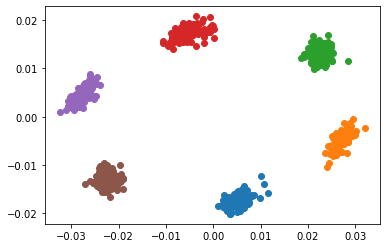

In [8]:
# let's plot PCA with 2 dim. since the original dimensionality of the data is 2 we can notice that 
# clusters appear very clearly and they are also separable
for e in projected_samples.view(n_samples, n_clusters, -1).transpose(0, 1):
    plt.scatter(*(e @ svd.U[:2].T).T)
plt.show()

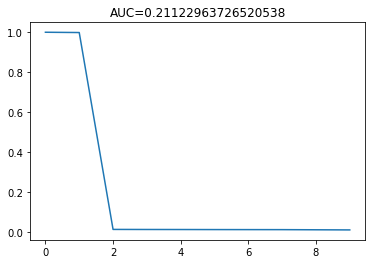

In [9]:
# AUC plot
normalized_eigenvalues = svd.S / svd.S.max()
plt.title(f"AUC={normalized_eigenvalues.mean()}")
plt.plot(normalized_eigenvalues)
plt.show()

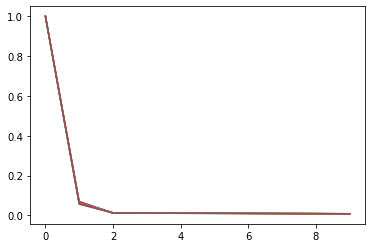

In [10]:
# local collapse of every single cluster (since they come from the same direction)
for e in projected_samples.view(n_samples, n_clusters, -1).transpose(0, 1):
    svd = e.svd()
    normalized_eigenvalues = svd.S / svd.S.max()
    plt.plot(normalized_eigenvalues)
plt.show()